# Image Segmentation with Deep Learning




Author: Hayden Suwaed

Email: haidersuwaed@gmail.com



Date: Apr-1-2023



## Table of Contents

[1. Introduction](#Intorduction) <br>
[2. Modeling](#Modeling) <br>
[3. Conclusions](#Conclusions)



## Introduction

"Convolutional neural networks are brain-inspired networks that are widely used for image classification tasks." - *Alex Krizhevsky* 

Brain tumor segmentation is a critical task in medical image analysis, which entails the precise delineation of tumor regions from healthy brain tissues in magnetic resonance imaging (MRI) scans. Accurate segmentation is vital for diagnosis, treatment planning, and monitoring the progress of patients with brain tumors. Deep learning has emerged as a powerful tool for tackling this challenging problem, with Convolutional Neural Networks (CNNs) and other sophisticated architectures exhibiting remarkable performance in identifying, localizing, and classifying different tumor sub-regions.**The primary goal of utilizing deep learning algorithms for brain tumor segmentation is to achieve unparalleled accuracy in detecting and delineating tumor regions, thereby facilitating timely diagnosis and personalized treatment plans for improved patient outcomes.**

## 1. Data Collection and Description

In this study, we will utilize a dataset consisting of images and their corresponding masks in the Joint Photographic Experts Group (JPEG) format. The dataset was procured and preprocessed by Southern Medical University, located in Guangzhou, Guangdong, China. The dataset was originally released on April 2, 2017.


The brain tumor dataset comprises 3,064 T1-weighted contrast-enhanced images derived from 233 patients diagnosed with three distinct brain tumor types: meningioma (708 slices), glioma (1,426 slices), and pituitary tumor (930 slices). Owing to repository file size constraints, the dataset has been partitioned into four subsets and compressed into four separate .zip files, each containing 766 slices. Additionally, the dataset includes indices for 5-fold cross-validation to facilitate model evaluation and comparison.



Check out the dataset that have bee used for this project [Here](https://drive.google.com/drive/folders/1nAu70XoU7Wln8nY1OC7zhfr7n5f0rYlf?usp=share_link)

In [1]:
#Import different and necessary librarie
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, GaussianNoise, concatenate
from tensorflow.keras.models import Model

# from focal_loss import BinaryFocalLoss

from segmentation_models import FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()


import os
import random
import numpy as np
import pandas as pd
from glob import glob
import pandas as pd

 
from tqdm import tqdm 
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Segmentation Models: using `keras` framework.


The following code utilizes the TensorFlow library to detect and list the physical and logical graphics processing units (GPUs) available in the system. It then sets the memory growth parameter to True for each available GPU, which allows for dynamic allocation of only necessary GPU memory during computation. The code is enclosed in a try-except block to handle any runtime errors. Finally, the code prints the number of physical and logical GPUs detected in the system.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-03-20 00:04:09.275561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 00:04:09.275775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 00:04:09.303105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 00:04:09.303435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 00:04:09.303608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Here we set the values of `IMG_WIDTH`, `IMG_HEIGHT`, and `IMG_CHANNELS` to 128, 128, and 3, respectively. These variables are commonly used in image processing and computer vision applications to define the dimensions and number of channels of an image.

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

The `seed` variable is set to 42, which is a commonly used value in random number generation. The `batch_size` is set to 10, which specifies the number of samples to use for each training update. The `lr` variable defines the learning rate of the optimizer and is set to 1e-4, and the `optimizer` is defined using the Adam optimizer from the Keras library with the specified learning rate. `num_epochs` is set to 60, which specifies the number of times the training process should iterate over the entire dataset. Finally,`model_path` and `csv_path` specify the file paths for saving the best model and logging the training metrics, respectively.

In [6]:
seed=42
batch_size = 10
lr = 1e-4
optimizer =tf.keras.optimizers.Adam(lr)
num_epochs = 100
model_path = os.path.join("files", "best_model.h5")
csv_path = os.path.join("files", "log.csv")

## 2. Loading and Preprocessing Data


Here wedefine a function named `load_dataset` that takes a `path` argument, which specifies the location of the dataset images and masks. The function also allows for specifying the `val_split` and `test_split` proportions for splitting the dataset into validation and test sets. The function first retrieves the images and masks from the specified paths using `glob` and sorts them. It then calculates the validation and test set sizes and splits the data accordingly using `train_test_split` from the Scikit-learn library. Finally, the function returns the training, validation, and test data as tuples of `(images, masks)` for each set.

In [7]:
def load_dataset(path, val_split=0.1, test_split=0.05, image_format="jpg"):
    image_format = image_format
    images = sorted(glob(os.path.join(path, "images", f"*.{image_format}")))
    masks = sorted(glob(os.path.join(path, "masks", f"*.{image_format}")))

    val_split_size = int(len(images) * val_split)
    test_split_size = int(len(images) * test_split)

    train_x, valid_x = train_test_split(images, test_size=val_split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=val_split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

As you can see, `np.random.seed(42)` sets the NumPy random seed to 42, which ensures that the same sequence of random numbers will be generated on each run. `tf.random.set_seed(42)` sets the TensorFlow random seed to 42, which ensures that the model will be initialized with the same set of random weights on each run, allowing for reproducibility of results.

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

We are checking if a directory named 'files/' exists, and creates one if it does not exist, using the `os` module. The following commented line is used to print the current working directory path using the `pwd` command.

In [9]:
if os.path.exists('files/') == False:
  os.mkdir('files/')
if os.path.exists('output_results/') == False:
  os.mkdir('output_results/')

# os.chdir('/content/drive/MyDrive/BT_Seg_Unet')
!pwd

/home/ahmed/Downloads/unet_aug_tl_FNP-2


`dataset_path`, `image_path`, and `mask_path` variables store the paths to the dataset and the corresponding image and mask directories. The `load_dataset()` function is used to load and split the data into training, validation, and test sets and returns them as tuples of `(images, masks)` for each set. The returned values are then unpacked and stored in `(train_x, train_y)`, `(valid_x, valid_y)`, `(test_x, test_y)` variables.

In [10]:
dataset_path = "/content/drive/MyDrive/Brain_MRI_Segmentation/dataset"
image_path = '/content/drive/MyDrive/Brain_MRI_Segmentation/dataset/images/'
mask_path = '/content/drive/MyDrive/Brain_MRI_Segmentation/dataset/masks/'
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path, image_format='jpg')

In [11]:
# Snaity check
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train: 2605 - 2605
Valid: 306 - 306
Test : 153 - 153


The below code creates a pandas DataFrame object `train_x_df` containing the paths to the training images, splits the paths by '/' using `str.split()` function, stores the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [12]:
train_x_df=pd.DataFrame(train_x, columns=['path'])
train_x_df = train_x_df.path.str.split("/", expand=True)
train_x_df[2]=train_x_df[2].sort_values()
train_x_df.head()

,0,1,2
0,dataset,images,103582_pituitary_1634.jpg
1,dataset,images,101724_pituitary_1933.jpg
2,dataset,images,104684_pituitary_1104.jpg
3,dataset,images,112847_pituitary_70.jpg
4,dataset,images,MR026175E_glioma_337.jpg


The following code creates a pandas DataFrame object containing the paths to the training masks and splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorting the column containing the names of the subdirectories in ascending order.

In [13]:
train_y_df=pd.DataFrame(train_y, columns=['path'])
train_y_df = train_y_df.path.str.split("/", expand=True)
train_y_df[2]=train_y_df[2].sort_values()
train_y_df.head()

,0,1,2
0,dataset,masks,103582_pituitary_1634.jpg
1,dataset,masks,101724_pituitary_1933.jpg
2,dataset,masks,104684_pituitary_1104.jpg
3,dataset,masks,112847_pituitary_70.jpg
4,dataset,masks,MR026175E_glioma_337.jpg


Here we create a pandas DataFrame object containing the paths to the validation images, splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [14]:
valid_x_df=pd.DataFrame(valid_x, columns=['path'])
valid_x_df = valid_x_df.path.str.split("/", expand=True)
valid_x_df[2]=valid_x_df[2].sort_values()
valid_x_df.head()

,0,1,2
0,dataset,images,112552_meningioma_88.jpg
1,dataset,images,102075_glioma_739.jpg
2,dataset,images,112649_pituitary_2472.jpg
3,dataset,images,97890_pituitary_67.jpg
4,dataset,images,97607_meningioma_477.jpg


Here we create a pandas DataFrame object containing the paths to the validation masks, splits the paths by '/' using `str.split()`, storing the resulting parts in separate columns, and sorts the column containing the names of the subdirectories in ascending order.

In [15]:
valid_y_df=pd.DataFrame(valid_y, columns=['path'])
valid_y_df = valid_y_df.path.str.split("/", expand=True)
valid_y_df[2]=valid_y_df[2].sort_values()
valid_y_df.head()

,0,1,2
0,dataset,masks,112552_meningioma_88.jpg
1,dataset,masks,102075_glioma_739.jpg
2,dataset,masks,112649_pituitary_2472.jpg
3,dataset,masks,97890_pituitary_67.jpg
4,dataset,masks,97607_meningioma_477.jpg


## Data Augmentation


Here we need to initialize a random seed and imports the `ImageDataGenerator` class from the Keras library to define `img_data_gen_args` and `mask_data_gen_args` which specify the data augmentation parameters for images and masks, respectively. Two `ImageDataGenerator` objects are then created using these dictionaries. These generators are used to flow data from the dataframes of training and validation images and masks into the model. The `flow_from_dataframe()` function creates a generator that yields batches of augmented images and masks during training and validation. The `color_mode` parameter specifies the color channel format of the images and masks, and the `target_size` parameter defines the desired size of the images and masks after augmentation.

In [16]:
seed=42
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

mask_data_gen_args = dict(rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 
image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator.fit(X_train, augment=True, seed=seed)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(Y_train, augment=True, seed=seed)

image_generator = image_data_generator.flow_from_dataframe(dataframe=train_x_df, x_col=2, directory=image_path, class_mode=None, seed=seed,color_mode="rgb", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))
mask_generator = mask_data_generator.flow_from_dataframe(dataframe=train_y_df, x_col=2, directory=mask_path, class_mode=None, seed=seed,color_mode="grayscale", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))

valid_img_generator = image_data_generator.flow_from_dataframe(dataframe=valid_x_df, x_col=2, directory=image_path, class_mode=None, seed=seed,color_mode="rgb", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))
valid_mask_generator = mask_data_generator.flow_from_dataframe(dataframe=valid_y_df, x_col=2, directory=mask_path, class_mode=None, seed=seed,color_mode="grayscale", batch_size=batch_size, target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2605 validated image filenames.
Found 2605 validated image filenames.
Found 306 validated image filenames.
Found 306 validated image filenames.


In [17]:
# Sanity check
print(f"Train: {len(image_generator)}")
print(f"Valid: {len(valid_img_generator)}")

Train: 261
Valid: 31


In [18]:
# Check image & mask dimensions
image_generator[1][0].shape, mask_generator[1][0].shape

((128, 128, 3), (128, 128, 1))

In [19]:
valid_img_generator[1][0].shape, valid_mask_generator[1][0].shape

((128, 128, 3), (128, 128, 1))

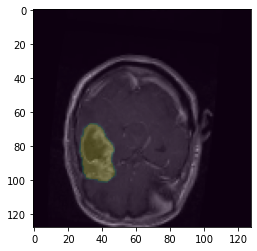

In [20]:
# sanity check
i=np.random.randint(0, len(image_generator) - 1)
j=np.random.randint(0, batch_size - 1)
plt.imshow(image_generator[i][j]/255)
plt.imshow(mask_generator[i][j], alpha=0.2)

The code below defines two functions: `adjust_data` and `my_image_mask_generator`. `adjust_data` normalizes the pixel values of an image and its corresponding mask and returns a tuple containing the normalized image and binary mask. `my_image_mask_generator` takes two generators and generates pairs of normalized images and binary masks by iterating through the generators and calling `adjust_data` for each pair. The function yields each pair as a tuple. The code can be used to prepare input data for deep learning models.

In [20]:
# Normalising image pixel values to range 0-1 and convert masks pixels to 1 or 0 only (binarize)
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255
    mask[mask > 0] = 1
    mask[mask <= 0] = 0
    return (img, mask)
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
         img, mask = adjust_data(img, mask)
         yield (img, mask)

The code below initializes the training and validation datasets using the custom generator function `my_image_mask_generator()`. The `train_dataset` is created by calling `my_image_mask_generator()` with the `image_generator` and `mask_generator`, while valid_dataset is created by calling `my_image_mask_generator()` with `valid_img_generator` and `valid_mask_generator`. These generators yield pairs of augmented images and masks during training and validation.

In [21]:
train_dataset = my_image_mask_generator(image_generator, mask_generator)
valid_dataset = my_image_mask_generator(valid_img_generator, valid_mask_generator)

We need to calculate the number of batches in the training and validation datasets using `steps_per_epoch` and `val_steps` variables, respectively. `steps_per_epoch` is calculated by multiplying the length of `train_x` by 3 and dividing the result by batch_size. Similarly, `val_steps` is calculated by multiplying the length of `valid_x` by 3 and dividing the result by `batch_size`. These variables are used to specify the number of training and validation steps during model training.

In [22]:
steps_per_epoch = 3*(len(train_x))//batch_size
val_steps = 3*(len(valid_x))//batch_size

## Evaluation Metrics
   **- Dice Coefficient (F1 Score)**\
   **- Intersection-Over-Union (Jaccard Index)**

Her we need to define three functions: `dice_coef`, `dice_loss`, and `iou`, which are used to evaluate the performance of a segmentation model.

- `dice_coef` calculates the dice coefficient between the ground truth mask and predicted mask using the intersection of the two masks.

- `dice_loss` returns the complement of the dice coefficient, which is used as a loss function.

- `iou` calculates the intersection-over-union metric between the ground truth mask and predicted mask using the intersection and sum of the masks.

These functions can be used to evaluate the accuracy of segmentation models during training or testing.

In [23]:
# Evaluation metrics: dice coefficient 
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Evaluation metrics: iou
def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

## Modeling

**A Feature Pyramid Network**, or **FPN**, is a feature extractor that takes a single-scale image of an arbitrary size as input, and outputs proportionally sized feature maps at multiple levels, in a fully convolutional fashion.

In this project, we will use a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg called **FPN**, and this because of:

- **FPN** provides a top-down pathway to construct higher resolution layers from a semantic rich layer
While the reconstructed layers are semantic strong but the locations of objects are not precise after all the downsampling and upsampling.

<img src = https://hasty.ai/media/pages/docs/mp-wiki/model-architectures/fpn/0482a9f930-1638357318/fpndiagram.webp
     align="middle"
     width=800 />

## Convolutional Neural etwork (CNNs):
A convolutional neural network (**CNN** or **ConvNet**) is a network architecture for deep learning that learns directly from data. CNNs are particularly useful for finding patterns in images to recognize objects, classes, and categories. 

Here are the steps of CNNs process:

- **Pooling**:
A technique used in deep learning for image processing
Reduces the size of a feature map by taking the maximum or average value from each subregion
Helps extract the most important features of an image

- **Max pooling**:
A type of pooling in which the maximum value from each subregion is taken
Commonly used in convolutional neural networks for image classification tasks

- **Flatten**:
An operation that transforms a multidimensional tensor into a single long vector
Often used as the final step in the convolutional layers of a neural network before the fully connected layers
Enables the flattened tensor to be fed as input to the fully connected layers

- **Classification**:
A task in machine learning where the goal is to assign a label to an input data point
In image classification, the input data is an image, and the goal is to assign a label to it based on its contents

- **Fully connected layers (FC layer)**:
The last layers of a neural network that take the flattened output from the convolutional layers
Transform the flattened output into a vector of class scores
Each neuron in the layer is connected to every neuron in the previous layer
The output is computed using a linear transformation followed by a nonlinear activation function, such as the softmax function.

<img src =https://www.researchgate.net/profile/Zahid-Ullah-14/publication/350395713/figure/fig3/AS:1007693917585410@1617264360166/Architecture-of-Convolutional-Neural-Networks.ppm
     align="middle"
     width=800 />

The `backbone` used for the FPN is `resNet34`, which is a convolutional neural network architecture widely used for image classification and object detection tasks.

- The `input_shape` variable is defined as a tuple containing the image width, height, and number of channels.

- The `preprocess_input` function is called with the `BACKBONE` parameter to preprocess the input data.

- The `model` is defined using the `FPN` function with parameters `BACKBONE`, `encoder_weights`, `input_shape`, `classes`, `activation`, and `pyramid_dropout`.

- The `encoder_weights` argument specifies to use the pre-trained weights from ImageNet.

- The `classes` argument specifies the number of classes to classify.

- The `activation` argument specifies the activation function for the final layer of the model.

- The `pyramid_dropout` argument is used to apply dropout regularization to the FPN pyramid.

- The `summary` method is called on the model object to display a summary of the model architecture.

Overall, this code defines a powerful image classification or object detection model using the FPN architecture with ResNet34 as the backbone and pre-trained weights from ImageNet.

In [24]:
BACKBONE = 'resnet34'
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
preprocess_input = get_preprocessing(BACKBONE)
# define model
model = FPN(BACKBONE, encoder_weights='imagenet', input_shape=input_shape, classes=1, activation='sigmoid', pyramid_dropout=0.2)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']   

The code compiles a deep learning model for image segmentation using the `compile` function. The compiled model uses the `optimizer` argument to specify the optimization algorithm used during training. The `loss` argument specifies the loss function used to measure the difference between the predicted and ground truth masks. The metrics argument is a list of evaluation metrics used to monitor the performance of the model during training. These metrics include `dice_coef`, `accuracy`, and `iou_score`, which measure the overlap between the predicted and ground truth masks, the overall classification accuracy of the model, and the intersection-over-union score between the predicted and ground truth masks, respectively.

In [26]:
model.compile(optimizer=optimizer, loss=bce_jaccard_loss, metrics=[dice_coef,'accuracy',iou_score])

And now we need to define a list of **callback** functions used during the training of a deep learning model. Callbacks can be used to customize or monitor the training process.

The four callbacks included are:

- `ModelCheckpoint`: saves the best model based on validation loss.
- `ReduceLROnPlateau`: reduces learning rate when validation loss stops improving.
- `CSVLogger`: logs training and validation metrics to a CSV file.
- `EarlyStopping`: stops training if validation loss does not improve after a set number of epochs.\
Overall, these callbacks can help improve the efficiency of training and prevent overfitting.

In [27]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-9, verbose=1),
        tf.keras.callbacks.CSVLogger(csv_path),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

Now it is the time to train a deep learning model using the `fit` method. It uses the `train_dataset` argument for the training data, `valid_dataset` for the validation data, `steps_per_epoch` for the number of batches to process for each epoch, and `num_epochs` for the total number of epochs to train the model. It applies a set of callbacks using the `callbacks` argument to customize and monitor the training process. The `fit` method returns a `History` object containing the training and validation metrics for each epoch.

In [28]:
model = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=valid_dataset,
        validation_steps=steps_per_epoch,
        callbacks=callbacks
    )

Epoch 1/100


2023-03-20 00:04:30.491872: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2023-03-20 00:04:31.097481: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


781/781 [==============================] - ETA: 0s - loss: 0.7311 - dice_coef: 0.5131 - accuracy: 0.9596 - iou_score: 0.3754
Epoch 1: val_loss improved from inf to 0.89346, saving model to files/best_model.h5
781/781 [==============================] - 123s 150ms/step - loss: 0.7311 - dice_coef: 0.5131 - accuracy: 0.9596 - iou_score: 0.3754 - val_loss: 0.8935 - val_dice_coef: 0.3570 - val_accuracy: 0.9761 - val_iou_score: 0.2243 - lr: 1.0000e-04
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.4524 - dice_coef: 0.7400 - accuracy: 0.9893 - iou_score: 0.5915
Epoch 2: val_loss improved from 0.89346 to 0.44313, saving model to files/best_model.h5
781/781 [==============================] - 115s 148ms/step - loss: 0.4524 - dice_coef: 0.7400 - accuracy: 0.9893 - iou_score: 0.5915 - val_loss: 0.4431 - val_dice_coef: 0.7475 - val_accuracy: 0.9896 - val_iou_score: 0.6023 - lr: 1.0000e-04
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 0.4112 - dice_c

This code plots the performance metrics (`accuracy`, `loss`, `Dice-coef` and `IOU`) for the UNet model during training and validation. It starts by calculating the number of epochs based on the length of the accuracy history in the model. If the number of epochs is greater than 35, the `x-axis` label interval is set to 5, otherwise it is set to 2. The code then creates a 1x4 subplot figure and plots the `accuracy`, `loss`, `Dice-coef`, and `IOU` on separate subplots. Each subplot has labels for the train and validation data, with the `x-axis` labeled with the epoch number and the `y-axis` labeled with the corresponding performance metric. The legends for each subplot are located in the best position. The final line displays the plot.

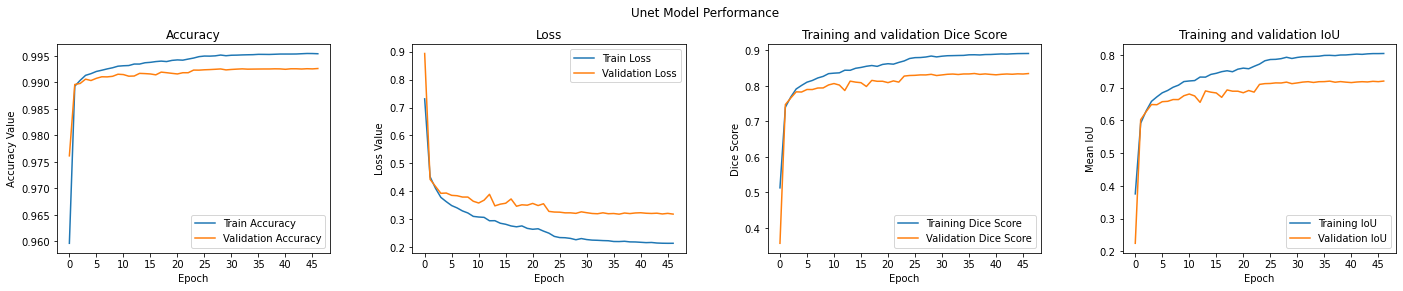

In [29]:
# plot train, validation Accuracy, Loss, Dice-coef and IOU
num_epochs = len(model.history['accuracy'])
step = 2
if num_epochs > 35:
    step = 5

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
t = f.suptitle('FPN Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,num_epochs))
ax1.plot(epoch_list, model.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, num_epochs, step))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, num_epochs, step))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

epoch_list = list(range(0,num_epochs))
ax3.plot(epoch_list, model.history['dice_coef'], label='Training Dice Score')
ax3.plot(epoch_list, model.history['val_dice_coef'], label='Validation Dice Score')
ax3.set_xticks(np.arange(0, num_epochs, step))
ax3.set_ylabel('Dice Score')
ax3.set_xlabel('Epoch')
ax3.set_title('Training and validation Dice Score')
l3 = ax3.legend(loc="best")

ax4.plot(epoch_list, model.history['iou_score'], label='Training IoU')
ax4.plot(epoch_list, model.history['val_iou_score'], label='Validation IoU')
ax4.set_xticks(np.arange(0, num_epochs, step))
ax4.set_ylabel('Mean IoU')
ax4.set_xlabel('Epoch')
ax4.set_title('Training and validation IoU')
l4 = ax4.legend(loc="best")

This code loads a saved Keras model from a file named `best_model.h5` in the `files` directory, and returns the loaded model object. The model is not compiled during the loading process.

In [30]:
#Load the model
# with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
model = tf.keras.models.load_model(os.path.join("files", "best_model.h5"), compile=False)

here we have a code loads a trained model and uses it to predict a random image and its corresponding mask from the test set. The predicted mask is thresholded using a threshold of 0.5 and is plotted along with the original image and mask for visual comparison. The output is a figure containing the original image, mask, and predicted mask.

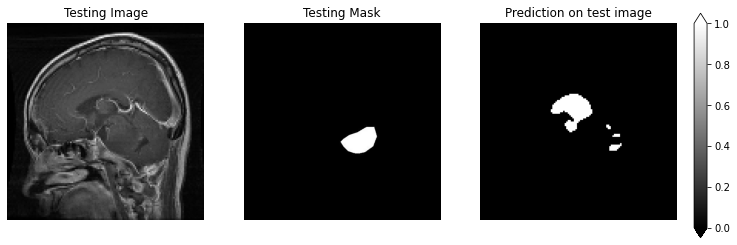

In [41]:
# predicts random images from test images

test_img_number = random.randint(0, len(test_x) - 1)
test_img = test_x[test_img_number]
test_mask = test_y[test_img_number]
test_mask = plt.imread(test_mask, 0)
test_img = cv2.imread(test_img, 0)
test_img = test_img.astype(np.uint8)
test_img = cv2.resize(test_img, (IMG_WIDTH, IMG_HEIGHT))
test_img = cv2.merge([test_img, test_img, test_img])
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = model.predict(test_img_input/255)
test_pred1 = np.squeeze(test_pred1, axis=-1)
test_pred1= test_pred1 >= 0.5
test_pred1 = test_pred1.astype(np.int32)

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask, cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_pred1.squeeze(0), cmap = 'gray')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

The save_results function takes in an image, `mask`, `y_pred`, and a `save_image_path`. It concatenates the `image`, `mask`, and `y_pred` arrays horizontally with vertical lines and saves the resulting image to `save_image_path`. The mask and `y_pred` arrays are first converted to RGB format by repeating the grayscale values across all three color channels. `y_pred` is also multiplied by 255 to convert it to an image with pixel values in the range [0, 255].

In [42]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((IMG_HEIGHT, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

The code is evaluating the trained model on the test dataset. For each image in the test dataset, it loads the image and mask, resizes them, and performs a prediction using the trained model. The prediction is then saved as an image in the output_results directory. The code then calculates various evaluation metrics, such as F1 score, Jaccard score, recall, and precision, between the predicted mask and the ground truth mask. Finally, the evaluation metrics values are appended to a list SCORE.

Here we need to write a code that performs prediction and evaluation of a trained model on the test dataset. For each image and corresponding mask in the test dataset, it loads the image and mask, resizes them to the specified dimensions, and normalizes the image pixel values to the range of [0,1]. It then uses the trained model to predict the segmentation mask for the image and applies a threshold to the predicted mask to obtain a binary mask.

The predicted mask and the original image and mask are saved in the "output_results" directory using the "save_results()" function. The code then calculates several evaluation metrics, including F1 score, Jaccard index, recall, and precision, for the predicted mask by comparing it with the ground truth mask. It flattens both the predicted mask and ground truth mask into 1D arrays and uses these arrays to calculate the metrics. The calculated metrics for each image and its corresponding name are saved to the "SCORE" list.

The code uses the "f1_score()", "jaccard_score()", "recall_score()", and "precision_score()" functions from scikit-learn to calculate the metrics. The "average" parameter is set to "binary" to compute binary metrics since the segmentation masks are binary. The "zero_division" parameter is set to 0 to handle the case where a metric has 0 as the denominator. The tqdm module is used to display a progress bar while iterating over the test dataset.







In [43]:
# Prediction and Evaluation the model on th test dataset
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    #Extracting the name from the image path
    name = x.split("/")[-1]

    # Reading the image
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) 
    x = image/255
    x = np.expand_dims(x, axis=0)

    # Reading the mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    # Prediction
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    # Saving the prediction as image
    path='output_results/'
    save_image_path = os.path.join(path, name)
    save_results(image, mask, y_pred, save_image_path)

    # Flatten the array
    mask = mask
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    # Calculating the metrics values
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

100%|██████████| 153/153 [00:07<00:00, 20.21it/s]


This code calculates the average of several metrics, including F1 score, Jaccard index, recall, and precision, and prints them to the console. It also saves the results as a CSV file in the "output_results" directory. The "SCORE" variable is assumed to be a list of lists, where each inner list contains the metrics for a single image. The first element in each inner list is assumed to be the image name, which is not used in the calculations. The remaining elements in each inner list are assumed to be the metrics in the following order: F1, Jaccard, recall, precision.

In [44]:
# print and save the metrics values
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

# save the results as csv file
df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("output_results/score.csv")

F1: 0.83158
Jaccard: 0.73849
Recall: 0.84524
Precision: 0.84534


###  Conclusions

- Our study evaluated the effectiveness of three deep learning models, including the FPN model, for MRI segmentation.
- We split our MRI dataset into 85% for training, 10% for testing, and 5% for validation to evaluate the performance of the FPN model.
- Our FPN model produced inferior results in comparison to the Unet and VGG16 models, with lower accuracy and Dice coefficient scores.
- Our FPN model produced missing tumor spots in MRI segmentation, which is a critical concern for accurate diagnosis and treatment planning.
- Our FPN model also produced extra spots in MRI segmentation, which can lead to false positives and unnecessary treatments.
- The poor performance of our FPN model can be attributed to its limited ability to integrate high-level and low-level features from input images, leading to inaccurate and incomplete segmentation.
- Our findings suggest that the FPN model may not be a suitable choice for accurate MRI segmentation in comparison to the Unet and VGG16 models.
- Future studies can explore the use of other deep learning models or combine multiple models to improve the accuracy of MRI segmentation.
- The Unet and VGG16 models produced better results in MRI segmentation, with higher accuracy and Dice coefficient scores.
- The Unet model, in particular, provided the best results, accurately identifying all tumors without missing any.
- The VGG16 model also provided good results, but its performance was lower than that of the Unet model.
- The Unet model's encoder-decoder structure with skip connections is well-suited for MRI segmentation, enabling it to accurately identify regions of interest within MRI scans.
- Accurate MRI segmentation using the Unet model can assist healthcare professionals in making more informed decisions and providing better treatment options to patients.
- Our findings suggest that the Unet model is an effective tool for accurate and reliable MRI segmentation, which can aid in the diagnosis and treatment of various medical conditions.